In [1]:
# %% Cell 1 - Install light NLP libs (run once)
# This only installs vaderSentiment and nltk (no pandas downgrade)
!pip install --quiet vaderSentiment nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.6 MB/s eta 0:00:00


In [2]:
# %% Cell 2 - Download NLTK data (run once)
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# %% Cell 3 - Imports & basic plotting config
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,5)

analyzer = SentimentIntensityAnalyzer()


In [22]:
# ===== Cell A: Load CSV (fresh) =====
DATA_PATH = "/synthetic_bank_tweets_1500_with_names.csv"   # your path

# Load file into a fresh DataFrame
df = pd.read_csv(DATA_PATH)

# Make a fresh, clean RangeIndex to avoid alignment issues later
df = df.reset_index(drop=True).copy()

print("Loaded dataframe shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head(5))


Loaded dataframe shape: (1500, 16)
Columns: ['user_name', 'bank_name', 'bank_type', 'platform', 'timestamp', 'text', 'category', 'sentiment_score', 'sentiment', 'likes', 'retweets', 'user_followers', 'is_reply', 'in_reply_to_bank_response', 'response_time_minutes', 'location']


user_name       bank_name bank_type platform            timestamp  \
0    Manish       Axis Bank   Private  Twitter  2024-09-02T13:54:18   
1   Keerthi  Bank of Baroda    Public  Twitter  2025-11-02T21:48:45   
2      Amit      ICICI Bank   Private  Twitter  2025-10-15T04:53:45   
3    Vivaan       Axis Bank   Private  Twitter  2025-11-01T19:30:08   
4     Kavya             SBI    Public  Twitter  2025-02-08T01:47:13   

                                                text   category  \
0  Axis Bank offered helpful service at the branc...    service   
1  Can't complete payment on Bank of Baroda. UPI ...    failure   
2  Claimed an offer from ICICI Bank and it worked...  promotion   
3  Axis Bank customer service resolved my issue q...    service   
4  Loving the cashback offer on SBI app today! #D...  promotion   

   sentiment_score sentiment  likes  retweets  user_followers  is_reply  \
0           -0.194  negative      1         0            7640     False   
1           -0.439  negative      6         0           15511      True   
2            0.702  positive      3         0           18699     False   
3            0.104  positive      4         1             122     False   
4            0.387  positive      1         1            3710     False   

   in_reply_to_bank_response  response_time_minutes          location  
0                       True                   70.0      Delhi, India  
1                       True                    5.0  Hyderabad, India  
2                       True                  120.0    Kolkata, India  
3                      False                    NaN    Chennai, India  
4                      False                    NaN      Delhi, India

In [23]:
# ===== Cell B: Ensure key columns exist, parse timestamp, safe lowercasing =====
# Ensure 'text' exists and is string
if 'text' not in df.columns:
    raise KeyError("CSV must contain a 'text' column. Please check file.")
df['text'] = df['text'].astype(str)

# Create cleaned text (keeps basic punctuation/currency)
import re
def clean_text_simple(s):
    if pd.isna(s):
        return ""
    s = re.sub(r'http\S+',' ', s)           # remove URLs
    s = re.sub(r'@\w+',' ', s)              # remove mentions
    s = re.sub(r'#',' ', s)                 # remove hash sign only
    s = re.sub(r'[^0-9a-zA-Z\s\.\,₹₹₹]', ' ', s)  # keep alnum, punctuation, currency symbols
    s = re.sub(r'\s+',' ', s).strip()
    return s

df['text_clean'] = df['text'].apply(clean_text_simple)
df['text_l'] = df['text_clean'].str.lower()

# Parse timestamp if present
if 'timestamp' in df.columns:
    df['ts'] = pd.to_datetime(df['timestamp'], errors='coerce')
else:
    df['ts'] = pd.NaT

# Normalize bank_type column
if 'bank_type' not in df.columns:
    df['bank_type'] = 'Unknown'
df['bank_type_filled'] = df['bank_type'].fillna('Unknown').astype(str)

print("Sample cleaned text:")
display(df[['text','text_clean','bank_name','bank_type_filled','ts']].head(5))


Sample cleaned text:


text  \
0  Axis Bank offered helpful service at the branc...   
1  Can't complete payment on Bank of Baroda. UPI ...   
2  Claimed an offer from ICICI Bank and it worked...   
3  Axis Bank customer service resolved my issue q...   
4  Loving the cashback offer on SBI app today! #D...   

                                          text_clean       bank_name  \
0  Axis Bank offered helpful service at the branc...       Axis Bank   
1  Can t complete payment on Bank of Baroda. UPI ...  Bank of Baroda   
2  Claimed an offer from ICICI Bank and it worked...      ICICI Bank   
3  Axis Bank customer service resolved my issue q...       Axis Bank   
4  Loving the cashback offer on SBI app today Dig...             SBI   

  bank_type_filled                  ts  
0          Private 2024-09-02 13:54:18  
1           Public 2025-11-02 21:48:45  
2          Private 2025-10-15 04:53:45  
3          Private 2025-11-01 19:30:08  
4           Public 2025-02-08 01:47:13

In [24]:
# ===== Cell C: Compute VADER sentiment safely (list -> numpy array -> assign) =====
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Compute compound scores as a plain Python list (order matches df)
texts = df['text'].astype(str).tolist()
vader_compound_list = [analyzer.polarity_scores(t)['compound'] for t in texts]

# Sanity check lengths
assert len(vader_compound_list) == len(df), "Length mismatch"

# Assign as NumPy array (avoids index alignment issues)
import numpy as np
df['vader_compound'] = np.array(vader_compound_list, dtype=float)

# Map to categorical labels (string dtype)
def _vader_label(v):
    if v > 0.05:
        return 'positive'
    if v < -0.05:
        return 'negative'
    return 'neutral'

df['vader_label'] = df['vader_compound'].map(_vader_label).astype(str)

print("VADER sample:")
display(df[['text_clean','vader_compound','vader_label']].head(8))


VADER sample:


text_clean  vader_compound  \
0  Axis Bank offered helpful service at the branc...          0.4215   
1  Can t complete payment on Bank of Baroda. UPI ...          0.0000   
2  Claimed an offer from ICICI Bank and it worked...          0.0000   
3  Axis Bank customer service resolved my issue q...          0.1779   
4  Loving the cashback offer on SBI app today Dig...          0.6360   
5  Transaction failed on HDFC Bank UPI money debi...         -0.5879   
6                UPI failed on SBI, very frustrating         -0.7574   
7  SBI promo gave instant discount, impressive Ca...          0.5106   

  vader_label  
0    positive  
1     neutral  
2     neutral  
3    positive  
4    positive  
5    negative  
6    negative  
7    positive

In [25]:
# ===== Cell D: Overall sentiment distribution (VADER) and compare with provided sentiment (if exists) =====
# VADER overall distribution
vader_overall = df['vader_label'].value_counts(normalize=True).mul(100).round(2).rename('pct').reset_index().rename(columns={'index':'vader_label'})
print("VADER overall distribution (%):")
display(vader_overall)

# If the dataset has a 'sentiment' or 'sentiment_score' column, show them for quick comparison
if 'sentiment' in df.columns:
    provided_dist = df['sentiment'].astype(str).value_counts(normalize=True).mul(100).round(2).rename('pct').reset_index().rename(columns={'index':'provided_sentiment'})
    print("Provided sentiment distribution (%):")
    display(provided_dist)
else:
    print("No provided 'sentiment' column in dataset.")


VADER overall distribution (%):


vader_label    pct
0    negative  36.47
1     neutral  35.33
2    positive  28.20

Provided sentiment distribution (%):


sentiment    pct
0  negative  58.73
1  positive  26.87
2   neutral  14.40

In [26]:
# ===== Cell E: Sentiment by bank_type (counts + percent within each bank_type) =====
# Compute counts by bank_type and vader_label
counts = df.groupby(['bank_type_filled','vader_label']).size().reset_index(name='count')

# Compute totals per bank_type
totals = df.groupby('bank_type_filled').size().reset_index(name='total_posts')

# Merge totals to compute percent within bank_type
counts = counts.merge(totals, on='bank_type_filled', how='left')
counts['pct_within_type'] = (counts['count'] / counts['total_posts'] * 100).round(2)

# Sort for readability
counts = counts.sort_values(['bank_type_filled','pct_within_type'], ascending=[True, False]).reset_index(drop=True)
print("Sentiment counts and percent within bank_type:")
display(counts)


Sentiment counts and percent within bank_type:


bank_type_filled vader_label  count  total_posts  pct_within_type
0          Private    negative    278          734            37.87
1          Private     neutral    259          734            35.29
2          Private    positive    197          734            26.84
3           Public     neutral    271          766            35.38
4           Public    negative    269          766            35.12
5           Public    positive    226          766            29.50

In [27]:
# ===== Cell F: Plot stacked bar of sentiment % by bank_type =====
# build pivot table (rows=bank_type, cols=vader_label) with pct_within_type
pivot = counts.pivot(index='bank_type_filled', columns='vader_label', values='pct_within_type').fillna(0)

# ensure columns order
cols_order = [c for c in ['negative','neutral','positive'] if c in pivot.columns]
ax = pivot[cols_order].plot(kind='bar', stacked=True, figsize=(10,5))
ax.set_title('Sentiment distribution (VADER) within bank_type')
ax.set_ylabel('Percent (%) within bank_type')
ax.set_xlabel('bank_type')
ax.legend(title='VADER label', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()


/tmp/ipython-input-2602766764.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  trend_pivot = trend.pivot(index='date', columns='bank_type_filled', values='vader_compound').fillna(method='ffill')


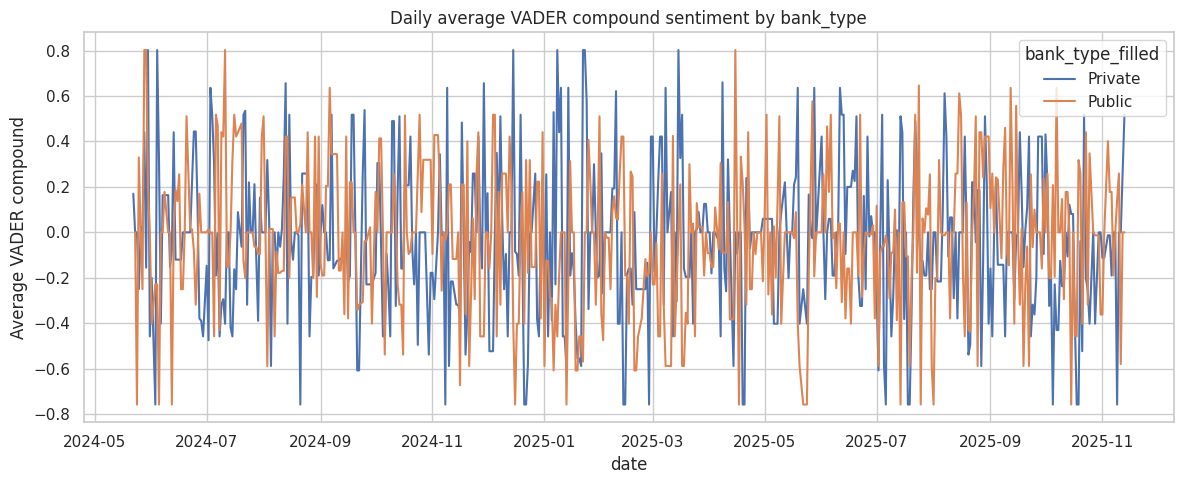

In [28]:
# ===== Cell G: Time-series trend (daily average VADER compound) — optional if timestamps exist =====
if df['ts'].notna().any():
    tmp = df.dropna(subset=['ts']).copy()
    tmp['date'] = tmp['ts'].dt.date
    trend = tmp.groupby(['date','bank_type_filled'])['vader_compound'].mean().reset_index()
    trend_pivot = trend.pivot(index='date', columns='bank_type_filled', values='vader_compound').fillna(method='ffill')
    trend_pivot.plot(figsize=(12,5))
    plt.title('Daily average VADER compound sentiment by bank_type')
    plt.ylabel('Average VADER compound')
    plt.xlabel('date')
    plt.tight_layout()
    plt.show()
else:
    print("No valid timestamps available for time-series plot.")
